<a href="https://colab.research.google.com/github/connorrupnow/CHEM507_machinelearning/blob/main/DNN_bandgap_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Neural Network Example**

In [ ]:
import math
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import feature_column
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


# The Data

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/CHEM507B/connors_applications/nomad2018-predict-transparent-conductors/test.csv')
train = pd.read_csv('/content/drive/MyDrive/CHEM507B/connors_applications/nomad2018-predict-transparent-conductors/train.csv')

In [ ]:
train.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


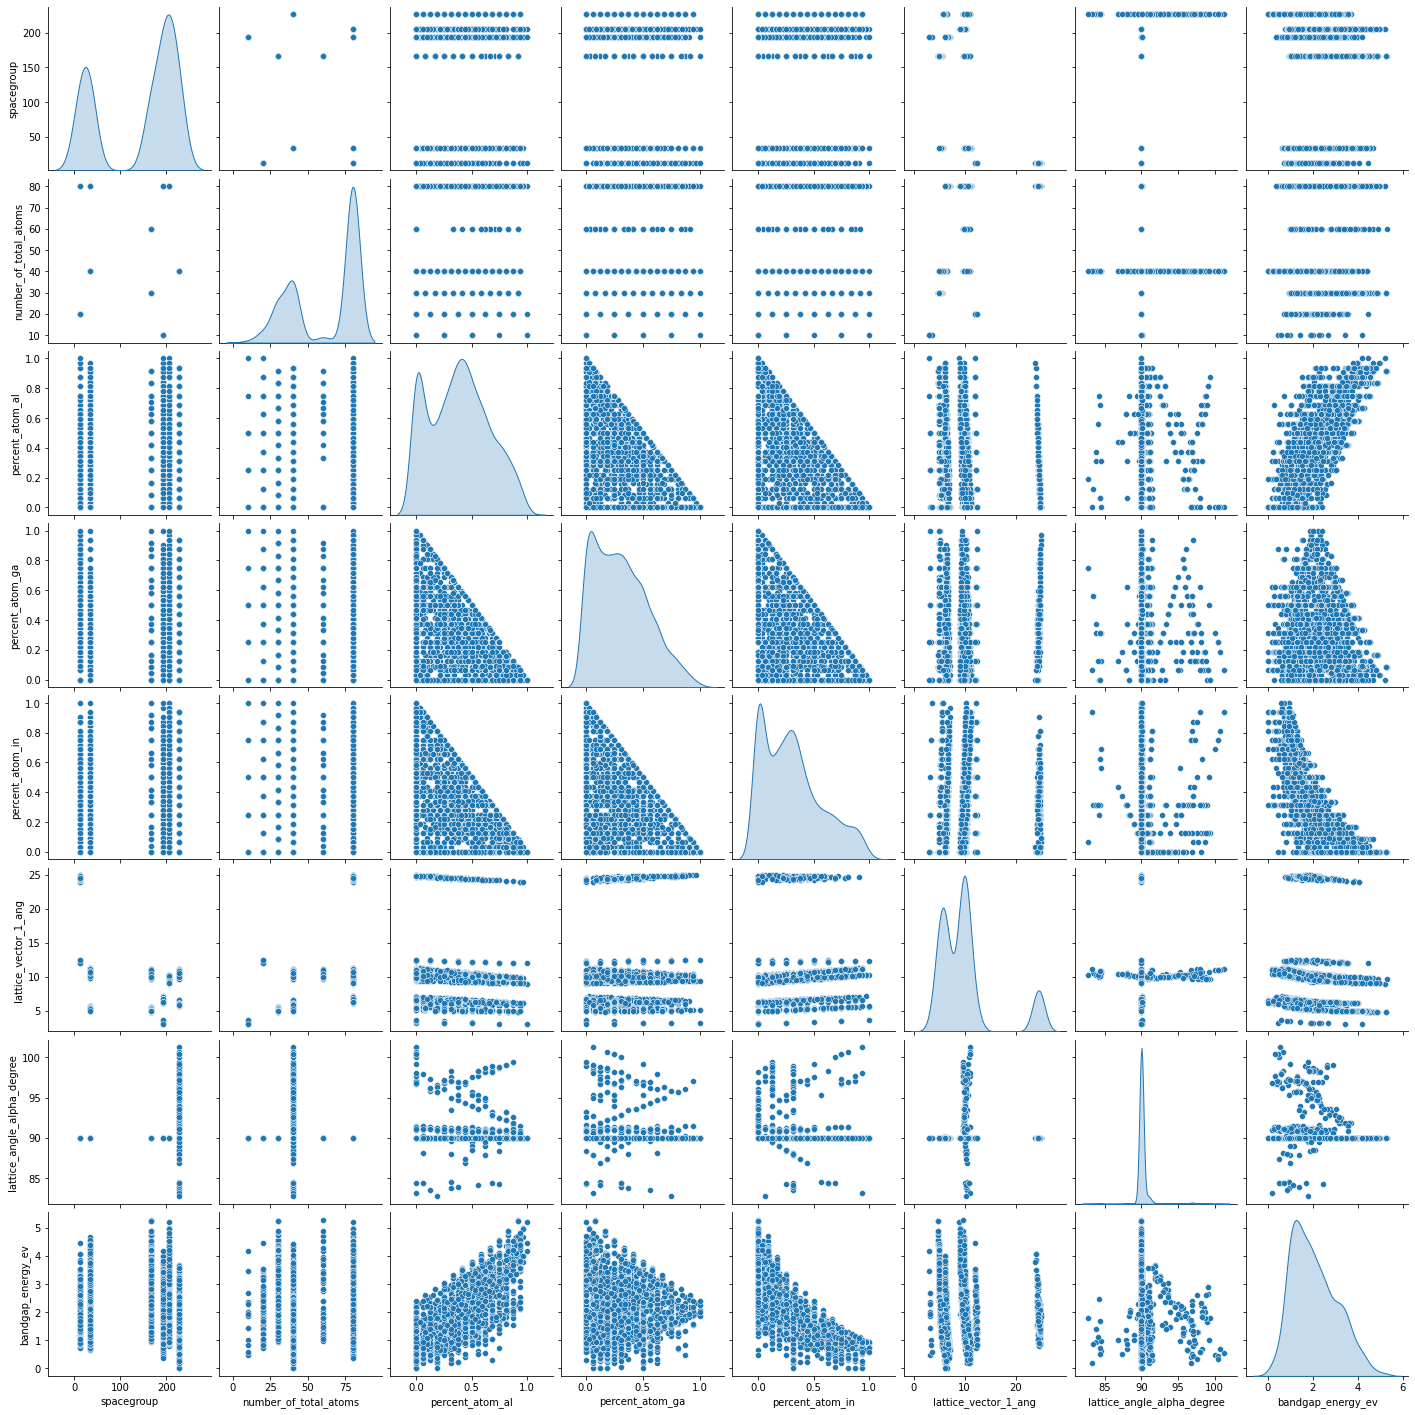

In [ ]:
sns.pairplot(train[['spacegroup', 'number_of_total_atoms','percent_atom_al','percent_atom_ga','percent_atom_in','lattice_vector_1_ang','lattice_angle_alpha_degree','bandgap_energy_ev']],diag_kind='kde')

In [ ]:
spacegroups = train.spacegroup.unique()
spacegroups.sort()
print(spacegroups)

n_spacegroups = len(spacegroups)

[ 12  33 167 194 206 227]


In [ ]:
number_of_atoms = train.number_of_total_atoms.unique()
number_of_atoms.sort()
print(number_of_atoms)

[10. 20. 30. 40. 60. 80.]


In [ ]:
t1 = 'formation_energy_ev_natom'
t2 = 'bandgap_energy_ev'

transform_columns = ['number_of_total_atoms', 'percent_atom_al', 'percent_atom_ga', 'percent_atom_in', 'lattice_vector_1_ang', 'lattice_vector_2_ang', 'lattice_vector_3_ang', 'lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree']
feature_columns = ['spacegroup'] + transform_columns

In [ ]:
# random_seed = 314

# X_train, X_validation = train_test_split(train, test_size=0.2, random_state=random_seed)

# y_train = np.log1p(X_train[[t2]])
# X_train = X_train.drop(['id', t1, t2], axis=1)

# y_validation = np.log1p(X_validation[[t2]])
# X_validation = X_validation.drop(['id', t1, t2], axis=1)

# print(X_train.shape, y_train.shape)
# print(X_validation.shape, y_validation.shape)

In [ ]:
random_seed = 314

X_train, X_validation = train_test_split(train, test_size=0.2, random_state=random_seed)

y_train = X_train[[t2]]
X_train = X_train.drop(['id', t1, t2], axis=1)

y_validation = X_validation[[t2]]
X_validation = X_validation.drop(['id', t1, t2], axis=1)

print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)

(1920, 11) (1920, 1)
(480, 11) (480, 1)


In [ ]:
X_train.head()

,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree
1064,167,30.0,0.7500,0.0833,0.1667,4.9604,4.9602,13.4383,89.9886,90.0123,120.0016
346,12,80.0,0.3750,0.3125,0.3125,24.4494,6.2373,6.1206,89.9998,104.6574,90.0001
1408,206,80.0,0.3750,0.3750,0.2500,9.4682,9.4679,9.4679,90.0031,90.0033,89.9967
590,194,80.0,0.1562,0.1250,0.7188,6.8634,6.8629,24.9061,90.0145,89.9956,119.9874
1583,206,80.0,0.0000,0.4375,0.5625,9.9024,9.9024,9.9023,90.0027,90.0023,89.9964


In [ ]:
# Is the sampling uniform? Compare mean and std dev of the training and validation data.

train_r1 = training_features['R1']
testing_r1 = testing_features['R1']
train_r1.head()

# Normalization

We can see from the data that there is a large range in the values of the features. 

For example, `spacegroup` is on the order of 10^2, `percent_atom_al` is on the order of 10^0, but `spacegroup` isn't necessarily 100x more important.

In [ ]:
X_train.describe().transpose()[['mean', 'std']]

,mean,std
spacegroup,142.765104,84.473544
number_of_total_atoms,61.427083,22.636187
percent_atom_al,0.386247,0.266386
percent_atom_ga,0.307957,0.233003
percent_atom_in,0.305794,0.263738
lattice_vector_1_ang,9.989472,5.592331
lattice_vector_2_ang,7.075924,1.895969
lattice_vector_3_ang,12.597293,5.410757
lattice_angle_alpha_degree,90.239386,1.318336
lattice_angle_beta_degree,92.357957,5.272687


Normalization processes the data to be on same scales. Although a model might converge without feature normalization, normalization makes training much more stable.

In [ ]:
X_validation.describe().transpose()[['mean', 'std']]

,mean,std
spacegroup,136.529167,85.583684
number_of_total_atoms,62.687500,22.441440
percent_atom_al,0.382205,0.262514
percent_atom_ga,0.311175,0.236782
percent_atom_in,0.306616,0.261299
lattice_vector_1_ang,10.192138,5.856330
lattice_vector_2_ang,7.131190,1.868905
lattice_vector_3_ang,12.577268,5.613594
lattice_angle_alpha_degree,90.260783,1.394542
lattice_angle_beta_degree,92.563025,5.409039


# Deep Neural Network Model

In [ ]:
# Build your DNN
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='relu', input_dim=11),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                240       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 22,641
Trainable params: 22,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              # optimizer=tf.optimizers.Adam(learning_rate=0.1),
              #loss=tf.keras.losses.CosineSimilarity(axis=-1, reduction="auto", name="cosine_similarity"),
              loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
              #loss=tf.keras.losses.MeanAbsoluteError(reduction="auto", name="mean_absolute_error"),
              #loss=tf.keras.losses.MeanSquaredLogarithmicError(reduction="auto", name="mean_squared_logarithmic_error"),
              #loss=tf.keras.losses.Huber(delta=1.0, reduction="auto", name="huber_loss"),
              #loss=tf.keras.losses.LogCosh(reduction="auto", name="log_cosh"),
              )

results = model.fit(X_train, y_train, epochs=100,verbose=0)

In [ ]:
predictions = model.predict(X_validation)

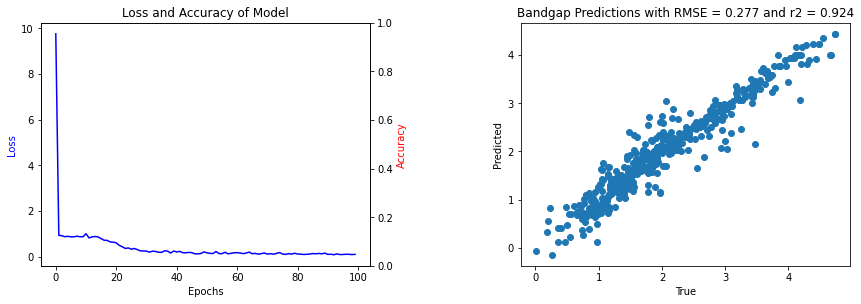

In [ ]:
# TODO consider increasing the size of the dots with larger error
predicted_values = predictions[:,0]
true_values = y_validation.bandgap_energy_ev
residuals = abs(true_values - predicted_values)

fig, [ax,ax2] = plt.subplots(1,2,figsize=(15,7))
fig.tight_layout(pad=12.0)

ax1 = ax.twinx() 
ax.plot(results.history['loss'],'b')
ax.set_xlabel('Epochs')
_ = ax.set_ylabel('Loss',color='b')
_ = ax1.set_ylabel('Accuracy',color='r')
ax.set_title('Loss and Accuracy of Model')


RMSE = np.sqrt(mean_squared_error(true_values,predicted_values))
r2 = r2_score(true_values,predicted_values)

x_min = min(true_values)
x_max = max(true_values)
x = np.linspace(x_min,x_max,100)
y = x

ax2.scatter(true_values,predicted_values)
#ax2.scatter(true_values,predicted_values,s=residuals*250)
ax2.set_xlabel('True')
ax2.set_ylabel("Predicted")
#ax2.plot(x,y,'r')
title = ax2.set_title('Bandgap Predictions with RMSE = %.3f and r2 = %.3f' % (RMSE, r2))

In [ ]:
# now lets normalize the data and try again
all = pd.concat([train[feature_columns], test])

#scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(all[transform_columns])

train[transform_columns] = scaler.transform(train[transform_columns])
test[transform_columns] = scaler.transform(test[transform_columns])

random_seed = 314

X_train, X_validation = train_test_split(train, test_size=0.2, random_state=random_seed)

y_train = np.log1p(X_train[[t2]])
X_train = X_train.drop(['id', t1, t2], axis=1)

y_validation = np.log1p(X_validation[[t2]])
X_validation = X_validation.drop(['id', t1, t2], axis=1)

print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)

(1920, 11) (1920, 1)
(480, 11) (480, 1)


In [ ]:
train.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,1,33,0.807795,0.907870,0.277313,-1.158917,-0.016138,0.769295,-0.621482,-0.176104,-0.453756,-0.199688,0.0680,3.4387
1,2,194,0.807795,0.907870,0.277313,-1.158917,-0.682195,-0.473610,2.031260,-0.163579,-0.454564,0.976205,0.2490,2.9210
2,3,227,-0.956912,1.609981,-0.516973,-1.158917,-0.051718,-0.748861,0.256971,0.580272,-0.243143,-2.531154,0.1821,2.7438
3,4,167,-1.398089,1.375944,-1.311259,-0.217959,-0.890833,-1.093304,0.177817,-0.186907,-0.451951,0.976173,0.2172,3.3492
4,5,194,0.807795,-1.432501,1.336362,0.252520,-0.597813,-0.222982,2.206125,-0.181271,-0.454075,0.975687,0.0505,1.3793


In [ ]:
# Build your DNN
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='relu', input_dim=11),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.summary()

model.compile(optimizer='adam',
              #loss=tf.keras.losses.CosineSimilarity(axis=-1, reduction="auto", name="cosine_similarity"),
              loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
              #loss=tf.keras.losses.MeanAbsoluteError(reduction="auto", name="mean_absolute_error"),
              #loss=tf.keras.losses.MeanSquaredLogarithmicError(reduction="auto", name="mean_squared_logarithmic_error"),
              #loss=tf.keras.losses.Huber(delta=1.0, reduction="auto", name="huber_loss"),
              #loss=tf.keras.losses.LogCosh(reduction="auto", name="log_cosh"),
              )

results = model.fit(X_train, y_train, epochs=100,verbose=0)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 20)                240       
_________________________________________________________________
dense_11 (Dense)             (None, 100)               2100      
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 101       
Total params: 22,641
Trainable params: 22,641
Non-trainable params: 0
_________________________________________________________________


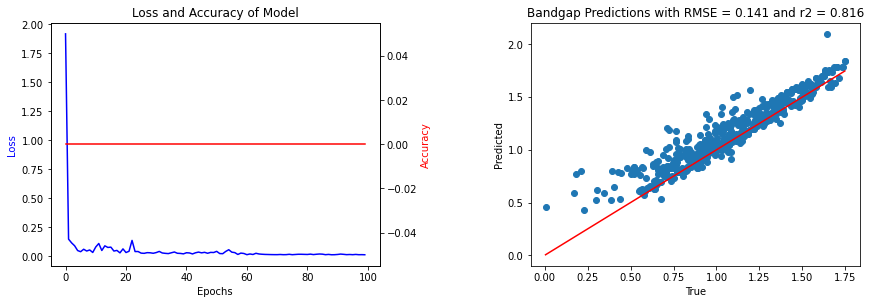

In [ ]:
predictions = model.predict(X_validation)

predicted_values = predictions[:,0]
true_values = y_validation.bandgap_energy_ev

fig, [ax,ax2] = plt.subplots(1,2,figsize=(15,7))
fig.tight_layout(pad=12.0)

ax1 = ax.twinx() 
ax.plot(results.history['loss'],'b')
ax1.plot(results.history['accuracy'],'r')
ax.set_xlabel('Epochs')
_ = ax.set_ylabel('Loss',color='b')
_ = ax1.set_ylabel('Accuracy',color='r')
ax.set_title('Loss and Accuracy of Model')


RMSE = np.sqrt(mean_squared_error(true_values,predicted_values))
r2 = r2_score(true_values,predicted_values)

x_min = min(true_values)
x_max = max(true_values)
x = np.linspace(x_min,x_max,100)
y = x

ax2.scatter(true_values,predicted_values)
ax2.set_xlabel('True')
ax2.set_ylabel("Predicted")
ax2.plot(x,y,'r')
title = ax2.set_title('Bandgap Predictions with RMSE = %.3f and r2 = %.3f' % (RMSE, r2))

# Performance

In [ ]:
hidden_layers=[1,2,3,4,5]
n_nodes = [10,20,50,100,200,500,1000]
RMSE = []
r2 = []

for hl in hidden_layers:
  for nodes in n_nodes:
    
    #build model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(11, activation='relu'))
    for i in range(hl):
      model.add(tf.keras.layers.Dense(nodes, activation='relu'))
    model.add(tf.keras.layers.Dense(1)) 

    #compile model
    model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"))

    #fit model
    results = model.fit(X_train, y_train, epochs=100,verbose=0)

    #make predictions
    predictions = model.predict(X_validation)

    #reformatting
    predicted_values = predictions[:,0]
    true_values = y_validation.bandgap_energy_ev

    # evaluate model
    RMSE.append(np.sqrt(mean_squared_error(true_values,predicted_values)))
    r2.append(r2_score(true_values,predicted_values))

In [ ]:
hlayers = []
nnodes = []
for hl in hidden_layers:
  for nodes in n_nodes:
    hlayers.append(hl)
    nnodes.append(nodes)

The lowest RMSE is for a model with 5 hidden layers and 1000 nodes per layer


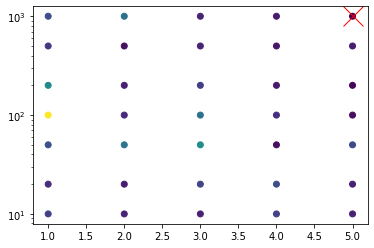

In [ ]:
plt.scatter(hlayers,nnodes,c=RMSE)
ax = plt.gca()
ax.set_yscale('log')

ind_min = np.argmin(RMSE)
plt.plot(hlayers[ind_min], nnodes[ind_min], color="red", marker="x", ms=20)
print('The lowest RMSE is for a model with', hlayers[ind_min],'hidden layers and', nnodes[ind_min],'nodes per layer')

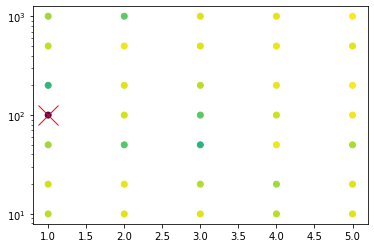

In [ ]:
plt.scatter(hlayers,nnodes,c=r2)
ax = plt.gca()
ax.set_yscale('log')

ind_min = np.argmin(r2)
plt.plot(hlayers[ind_min], nnodes[ind_min], color="red", marker="x", ms=20)

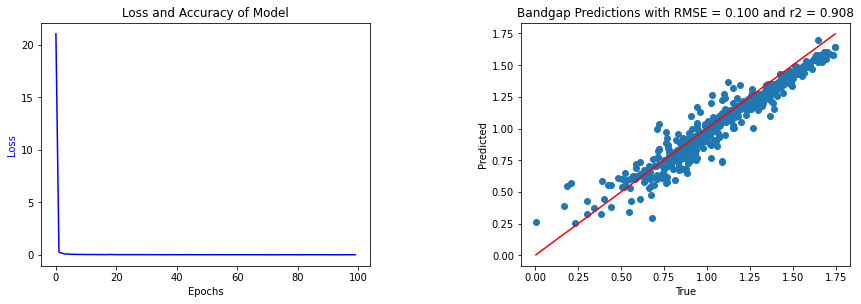

In [ ]:
hl = 5
nodes = 1000

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(20, activation='relu', input_dim=11))
for i in range(hl):
  model.add(tf.keras.layers.Dense(nodes, activation='relu'))
model.add(tf.keras.layers.Dense(1)) 

model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"))

results = model.fit(X_train, y_train, epochs=50,verbose=0)

predictions = model.predict(X_validation)

predicted_values = predictions[:,0]
true_values = y_validation.bandgap_energy_ev

fig, [ax,ax2] = plt.subplots(1,2,figsize=(15,7))
fig.tight_layout(pad=12.0)


ax.plot(results.history['loss'],'b')
ax.set_xlabel('Epochs')
_ = ax.set_ylabel('Loss',color='b')
ax.set_title('Loss and Accuracy of Model')

RMSE = np.sqrt(mean_squared_error(true_values,predicted_values))
r2 = r2_score(true_values,predicted_values)

x_min = min(true_values)
x_max = max(true_values)
x = np.linspace(x_min,x_max,100)
y = x

ax2.scatter(true_values,predicted_values)
ax2.set_xlabel('True')
ax2.set_ylabel("Predicted")
ax2.plot(x,y,'r')
title = ax2.set_title('Bandgap Predictions with RMSE = %.3f and r2 = %.3f' % (RMSE, r2))

In [ ]:
RMSE

0.0997570487970628